# Mask Creation CIFAR10 Convbig
## Imports

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import scipy
import os
os.chdir('../')

/usr/local/anaconda3/envs/alpha-beta-crown/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Function Definitions

In [2]:

def scores_to_local_ranks(scores_list):
    ranks_list = []
    for scores in scores_list:
        #record shape of layer
        shape = scores.size()
        scores = scores.flatten()
        temp = torch.argsort(scores)
        ranks = torch.empty_like(temp)
        # replace score by rank
        ranks[temp] = torch.arange(len(temp))
        # min will always be 0 -> normalisation just division by max, then reshaping
        ranks = (ranks / ranks.max()).reshape(shape)
        ranks_list.append(ranks)
    return ranks_list

In [3]:
def scores_to_global_ranks_old(scores_list):
    # record shapes and number of elements for all layers
    shape_list = [layer.size() for layer in scores_list]
    splitindex_list = np.cumsum([layer.numel() for layer in scores_list]).tolist()
    splitindex_list = [0] + splitindex_list[:-1]
    # flatten scores globally over all layers, rank and normalize
    all_scores = torch.cat([layer.flatten() for layer in scores_list])
    temp = torch.argsort(all_scores)
    ranks = torch.empty_like(temp)
    # replace score by rank
    ranks[temp] = torch.arange(len(temp))
    # min will always be 0 -> normalisation just division by max
    ranks = ranks / ranks.max()
    # split flattened list and reshape accordingly
    ranks_list = [ranks[i:j] for i,j in zip(splitindex_list, splitindex_list[1:]+[None])]
    ranks_list = [torch.reshape(ranks_list[i], shape_list[i]) for i in range(len(ranks_list))]
    return ranks_list

In [4]:
def scores_to_global_ranks(scores_list, method = 'min'):
    if method == 'argsort':
        return scores_to_global_ranks_old(scores_list)
    if method == 'norank':
        ma = max([l.max() for l in scores_list])
        mi = min([l.min() for l in scores_list])
        return [(l-mi)/(ma-mi) for l in scores_list]
    # record shapes and number of elements for all layers
    shape_list = [layer.size() for layer in scores_list]
    splitindex_list = np.cumsum([layer.numel() for layer in scores_list]).tolist()
    splitindex_list = [0] + splitindex_list[:-1]
    # flatten scores globally over all layers, rank and normalize
    all_scores = torch.cat([layer.flatten() for layer in scores_list])

    ### RANKING AND NORMALISATION
    ranks = torch.Tensor(scipy.stats.rankdata(all_scores, method = method))
    ranks = ranks - ranks.min()
    ranks = ranks / ranks.max()

    # split flattened list and reshape accordingly
    ranks_list = [ranks[i:j] for i,j in zip(splitindex_list, splitindex_list[1:]+[None])]
    ranks_list = [torch.reshape(ranks_list[i], shape_list[i]) for i in range(len(ranks_list))]
    return ranks_list

In [5]:
def local_mask_from_ranks(inst_ranks, sig_ranks, gammas, ratios):
    assert len(inst_ranks) == len(sig_ranks), "Score list lengths have to match"
    mask_list = []
    idcs_list = []
    # local mask selects layerwise
    for inst_layer, sig_layer in zip(inst_ranks, sig_ranks):
        assert inst_layer.size() == sig_layer.size(), "Shapes of score list elements have to match"
        idcs = []
        flat_inst_layer = inst_layer.flatten()
        flat_sig_layer = sig_layer.flatten()
        #select neurons in different stages of gamma
        for gamma, ratio in zip(gammas, ratios):
            # this is the case if we only ranks using instability score
            if gamma == float('+inf'):
                flat_scores = flat_inst_layer
            else:
                flat_scores = gamma*flat_inst_layer - flat_sig_layer
            # already selected neurons are assigned -inf score to not be selected again
            flat_scores[idcs] = float('-inf')
            remain_count = round(ratio*flat_scores.numel())
            new_idcs = torch.argsort(-flat_scores).tolist()[:remain_count]
            idcs += new_idcs
        mask = torch.zeros_like(inst_layer)
        mask.reshape(-1)[idcs] = 1
        mask_list.append(mask)  
        idcs_list.append(idcs)      
    return mask_list, idcs_list

In [6]:
def global_mask_from_ranks(inst_ranks, sig_ranks, gammas, ratios):
    assert len(inst_ranks) == len(sig_ranks), "Score lists have to be of same length"
    shape_list = [layer.size() for layer in inst_ranks]
    shape_list_alt = [layer.size() for layer in sig_ranks]
    assert shape_list == shape_list_alt, "Layerwise shapes have to be equal for both score lists"
    splitindex_list = np.cumsum([layer.numel() for layer in inst_ranks]).tolist()
    splitindex_list = [0] + splitindex_list[:-1]
    flat_inst_ranks = torch.cat([layer.flatten() for layer in inst_ranks])
    flat_sig_ranks = torch.cat([layer.flatten() for layer in sig_ranks])
    idcs = []
    for gamma, ratio in zip(gammas, ratios):
        # this is the case if we only ranks using instability score
        if gamma == float('+inf'):
            flat_scores = flat_inst_ranks
        else:
            flat_scores = gamma*flat_inst_ranks - flat_sig_ranks
        # already selected neurons are assigned -inf score to not be selected again
        flat_scores[idcs] = float('-inf')
        remain_count = round(ratio*flat_scores.numel())
        #print(f'grafting count: {remain_count} for gamma {gamma} and ratio {ratio}')
        new_idcs = torch.argsort(-flat_scores).tolist()[:remain_count]
        idcs += new_idcs
    # split flattened list and reshape accordingly
    mask = torch.zeros_like(flat_inst_ranks)
    mask[idcs] = 1
    mask_list = [mask[i:j] for i,j in zip(splitindex_list, splitindex_list[1:]+[None])]
    mask_list = [torch.reshape(mask_list[i], shape_list[i]) for i in range(len(mask_list))]
    return mask_list, idcs

In [7]:
def global_random_mask_from_ranks(ranks_list, ratios):
    shape_list = [layer.size() for layer in ranks_list]
    splitindex_list = np.cumsum([layer.numel() for layer in ranks_list]).tolist()
    splitindex_list = [0] + splitindex_list[:-1]
    remain_ratio = sum(ratios)
    n = torch.cat([layer.flatten() for layer in ranks_list]).numel()
    index = np.random.permutation(n)[:round(remain_ratio*n)]
    mask = torch.zeros(n)
    mask[index] = 1
    # split flattened list and reshape accordingly
    mask_list = [mask[i:j] for i,j in zip(splitindex_list, splitindex_list[1:]+[None])]
    mask_list = [torch.reshape(mask_list[i], shape_list[i]) for i in range(len(ranks_list))]
    return mask_list

In [8]:
def local_random_mask_from_ranks(ranks_list, ratios):
    mask_list = []
    remain_ratio = sum(ratios)
    for layer in ranks_list:
        n = layer.numel()
        index = np.random.permutation(n)[:round(remain_ratio*n)]
        temp = torch.zeros(n)
        temp[index] = 1
        mask_list.append(temp.reshape(layer.size()))    
    return mask_list

In [9]:
def mask_list_to_idcs(mask_list):
    return torch.cat([layer.flatten() for layer in mask_list]).nonzero().flatten().tolist()

In [10]:
def print_mask_stats(mask_list):
    num = sum([layer.numel() for layer in mask_list])
    count = sum([layer.sum() for layer in mask_list])
    print(f'# Neurons total: {num}')
    print(f'# Neurons grafted: {count}')
    print(f'Total grafting percentage {count/num:.10f}')
    print(f'Layerwise grafting counts of own mask: {[layer.sum().item() for layer in mask_list]}')
    print(f'Layerwise grafting percentages of own mask: {[((layer.sum()/layer.numel()).item()) for layer in mask_list]}')

## Load scores and calculate mask

In [11]:
weights_path = "ConvBig_CIFAR10/Train/Model/model_RA_best.pth.tar"

grad_scores_path = 'ConvBig_CIFAR10/Graft/Scores/score_gradient.pth'
mag_scores_path = 'ConvBig_CIFAR10/Graft/Scores/score_magnitude.pth'
var_scores_path = 'ConvBig_CIFAR10/Graft/Scores/score_variance.pth'
inst_scores_path = 'ConvBig_CIFAR10/Graft/Scores/score_instability.pth'


In [12]:
grad_scores = torch.load(grad_scores_path)
mag_scores = torch.load(mag_scores_path)
var_scores = torch.load(var_scores_path)
inst_scores = torch.load(inst_scores_path)

/var/folders/z5/yqd1shk93k5750y70gcq3tgw0000gn/T/ipykernel_39054/730667327.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


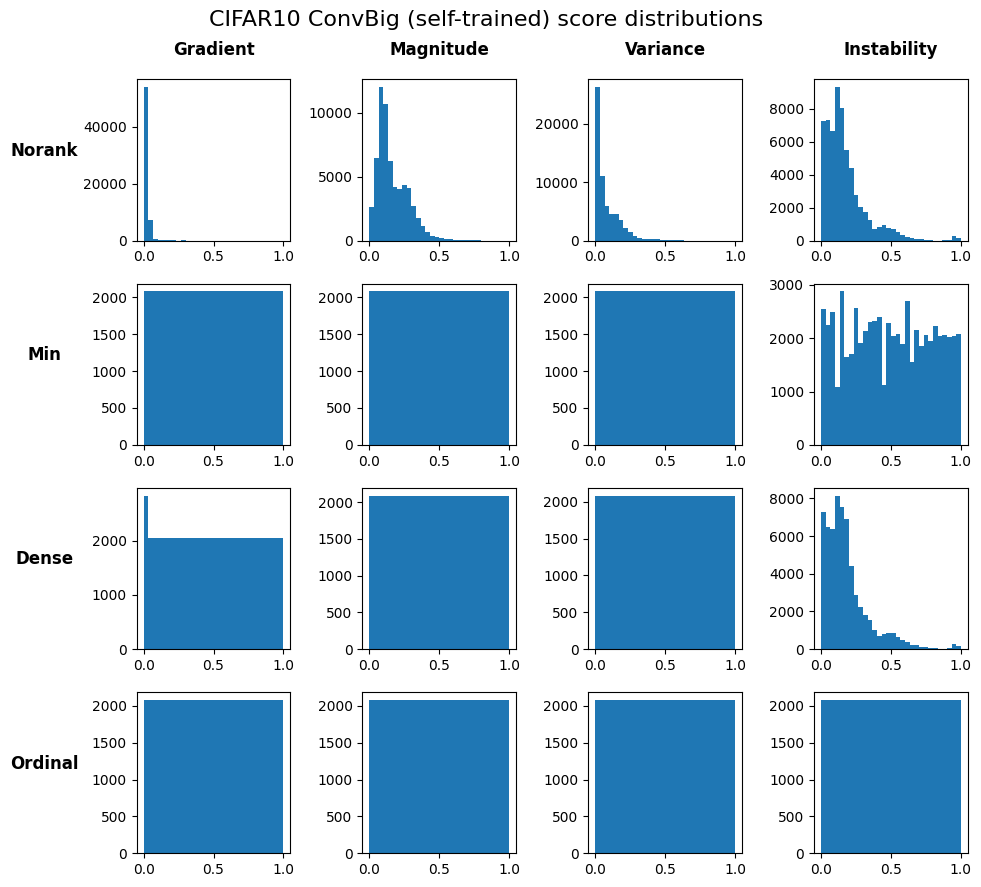

In [13]:
methods = ['norank', 'min', 'dense', 'ordinal']
method_names = ['Norank', 'Min', 'Dense', 'Ordinal']
names = ['Gradient', 'Magnitude', 'Variance', 'Instability']
scoresList = [grad_scores, mag_scores, var_scores, inst_scores]
fig, axarr = plt.subplots(nrows = len(methods), ncols = len(scoresList), figsize = (10, 9))
for i,m in enumerate(methods):
    for j, s in enumerate(scoresList):
        temp = scores_to_global_ranks(s, method = m)
        temp = torch.cat([l.flatten() for l in temp])
        axarr[i][j].hist(temp, bins = 30)
        if i == 0:
            axarr[i][j].set_title(f'{names[j]}', y = 1.1, fontweight = "bold")
        if j == 0:
            axarr[i][j].set_ylabel(method_names[i], rotation=0, size='large', fontweight = "bold")
            axarr[i][j].yaxis.set_label_coords(-0.6, 0.5)
fig.suptitle("CIFAR10 ConvBig (self-trained) score distributions", fontsize = 16)
fig.tight_layout()
fig.savefig('graphics/distribution_test.pdf')
fig.show()

/var/folders/z5/yqd1shk93k5750y70gcq3tgw0000gn/T/ipykernel_39054/2290621910.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


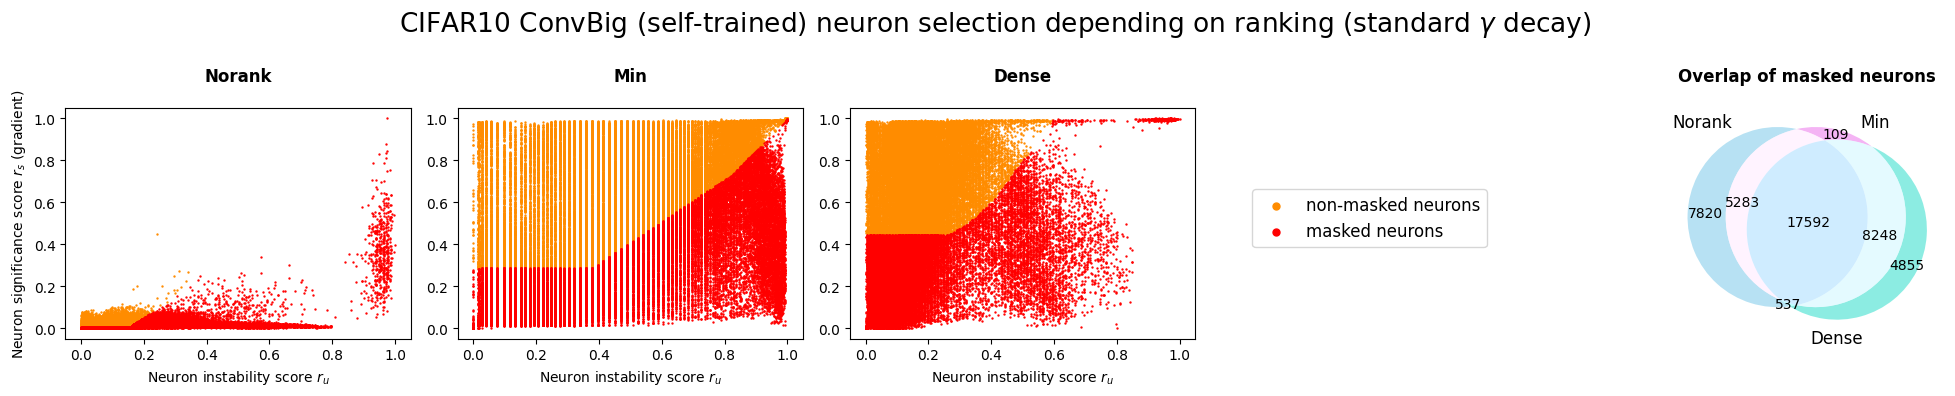

In [14]:
methods = ['norank', 'min', 'dense']
method_names = ['Norank', 'Min', 'Dense']
sig_scores = grad_scores
heuristic = 'gradient'
gammas = [2, 1.5, 1, 0]
ratios = [0.125, 0.125, 0.125, 0.125]
fig, axarr = plt.subplots(nrows = 1, ncols = 5, figsize = (20, 4))
idcs_dict = {}

for i, method in enumerate(methods):
    inst_ranks = scores_to_global_ranks(inst_scores, method = method)
    grad_ranks = scores_to_global_ranks(sig_scores, method = method)
    mask, mask_idcs = global_mask_from_ranks(inst_ranks, grad_ranks, gammas, ratios)
    flatinst = torch.cat([l.flatten() for l in inst_ranks])
    flatgrad = torch.cat([l.flatten() for l in grad_ranks])
    idcs_dict[method] = mask_idcs

    # flatinst = torch.Tensor(np.linspace(0, 1, num = 1000))
    # flatgrad = torch.Tensor(np.random.uniform(0,1,(1000,)))
    # mask_idcs = np.random.permutation(1000)[:500]
    # idcs_dict[method] = mask_idcs

    non_masked = [i for i in range(len(flatgrad)) if i not in mask_idcs]
    l =axarr[i].scatter(flatinst[non_masked], flatgrad[non_masked], c = "darkorange", label = "non-masked neurons", s = 0.5)    
    axarr[i].scatter(flatinst[mask_idcs], flatgrad[mask_idcs], c = "r", label = "masked neurons", s = 0.5)
    axarr[i].set_title(f'{method_names[i]}', y = 1.08, fontweight = 'bold')
    axarr[i].set_xlabel(r'Neuron instability score $r_u$')
    if i == 0:
        axarr[i].set_ylabel(r'Neuron significance score $r_s$ ('+heuristic+')')
        # collect legend data from one random plot
        handles, labels = axarr[i].get_legend_handles_labels()

# hide 4th plot to position legend
axarr[3].axis('off')

venn3([set(idcs_dict[methods[i]]) for i in range(len(methods))], set_labels = method_names, ax = axarr[4], set_colors=('skyblue', 'violet', 'turquoise'), alpha = 0.6)
axarr[4].set_title('Overlap of masked neurons', y = 1.08, fontweight = 'bold')

# figure legend
lgnd = fig.legend(handles, labels, bbox_to_anchor=[0.75, 0.55], prop={'size': 12})
#adjust size of scatter points
lgnd.legend_handles[0]._sizes = [25]
lgnd.legend_handles[1]._sizes = [25]

fig.suptitle(r"CIFAR10 ConvBig (self-trained) neuron selection depending on ranking (standard $\gamma$ decay)", fontsize = 19)#\n\
fig.tight_layout()
fig.savefig('graphics/scatterplot_test.pdf')
fig.show()

In [15]:
# ranking method determines treatment for equal scores
method = 'dense'

grad_ranks = scores_to_global_ranks(grad_scores, method = method)
mag_ranks = scores_to_global_ranks(mag_scores, method = method)
var_ranks = scores_to_global_ranks(var_scores, method = method)
inst_ranks = scores_to_global_ranks(inst_scores, method = method)

In [16]:
flat_scores = torch.cat([layer.flatten() for layer in inst_scores])
print(flat_scores.size())
print(flat_scores.unique().size())

flat_scores = torch.cat([layer.flatten() for layer in grad_scores])
print(flat_scores.size())
print(flat_scores.unique().size())


torch.Size([62464])
torch.Size([217])
torch.Size([62464])
torch.Size([61631])


## Comparison of Significance Heuristics: Grafted Neuron Indices

### Calculate masks from provided score lists (own method)

The grafting score of a neuron is calculated like this: 

$\gamma \times r_u - r_s$

where $r_u$ is the normalised instability score and $r_s$ is the normalised significance score. Neurons are selected in portions with a decaying $\gamma$, progressively weighing instability more than insignificance. 
For $\gamma \rightarrow 0, \infty$ the score is only based on insignificance / instability.

Different significance heuristics:
* mean absolute activation magnitude
* mean absolute activation gradient (standard setting in paper)
* activation magnitude variance (**newly implemented**)

In [17]:
# Standard setting:
gammas = [2, 1.5, 1, 0]
ratios = [0.125, 0.125, 0.125, 0.125]

# # Other setting:
# gammas = [2, 0]
# ratios = [0.25, 0.25]

# # Only conider instability score, indices should all be the same:
# gammas = [float("inf")]
# ratios = [0.5]

# Only consider significance score, indices should differ maximally:
# gammas = [0]
# ratios = [0.5]

var_mask, ordered_var_idcs = global_mask_from_ranks(inst_ranks, var_ranks, gammas, ratios)
grad_mask, ordered_grad_idcs = global_mask_from_ranks(inst_ranks, grad_ranks, gammas, ratios)
mag_mask, ordered_mag_idcs = global_mask_from_ranks(inst_ranks, mag_ranks, gammas, ratios)


In [18]:
torch.save(grad_mask, 'ConvBig_CIFAR10/Graft/Masks/TEST_grad_mask_stdg_norank')

In [19]:
[l.size() for l in var_mask]

[torch.Size([32, 32, 32]),
 torch.Size([32, 16, 16]),
 torch.Size([64, 16, 16]),
 torch.Size([64, 8, 8]),
 torch.Size([512]),
 torch.Size([512])]

### How much do the calculated masks differ? Comparison of grafted neurons depending on significance heuristic

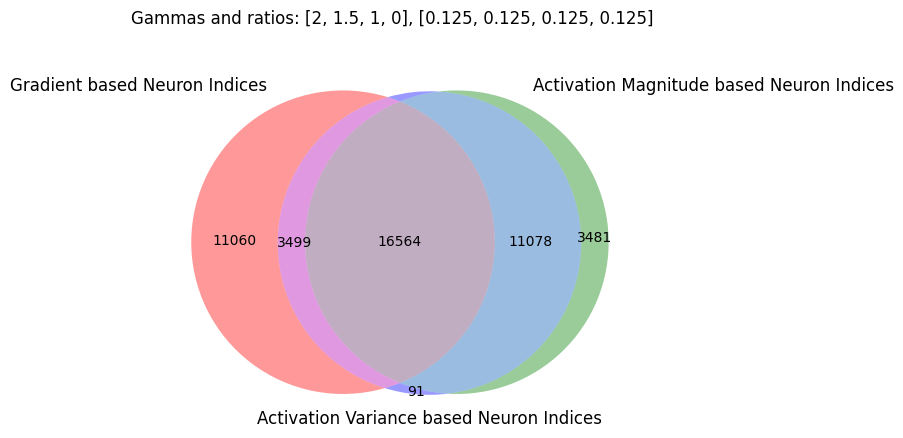

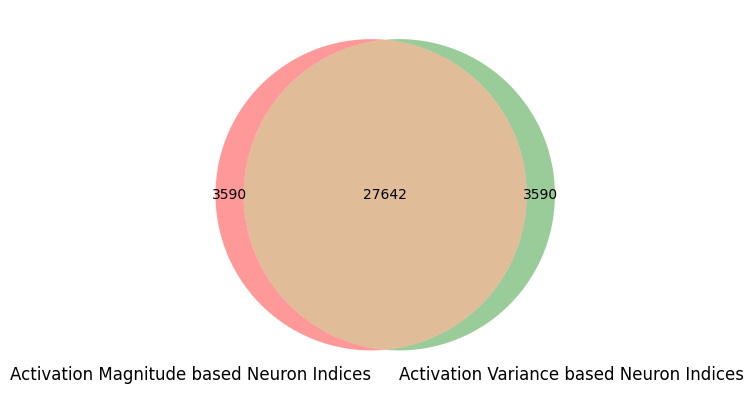

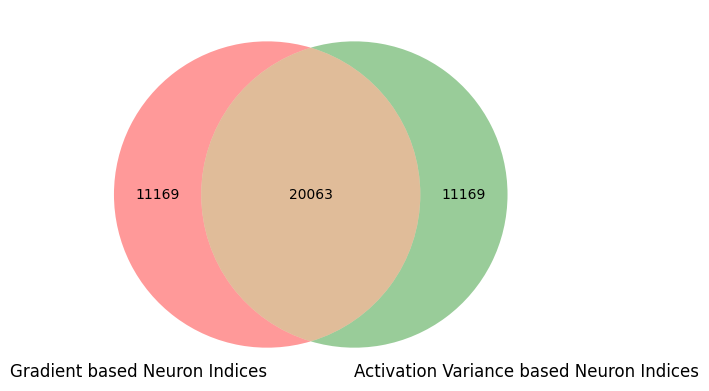

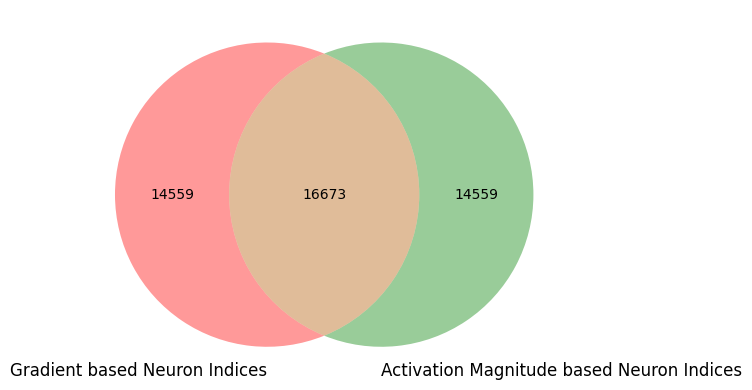

In [20]:
venn3([set(ordered_grad_idcs),set(ordered_mag_idcs), set(ordered_var_idcs)], ["Gradient based Neuron Indices", "Activation Magnitude based Neuron Indices", "Activation Variance based Neuron Indices"])
plt.suptitle("Gammas and ratios: " + str(gammas) + ", " + str(ratios))
plt.show()

venn2([set(ordered_mag_idcs), set(ordered_var_idcs)], ["Activation Magnitude based Neuron Indices", "Activation Variance based Neuron Indices"])
plt.show()

venn2([set(ordered_grad_idcs),set(ordered_var_idcs)], ["Gradient based Neuron Indices","Activation Variance based Neuron Indices"])
plt.show()

venn2([set(ordered_grad_idcs),set(ordered_mag_idcs)], ["Gradient based Neuron Indices", "Activation Magnitude based Neuron Indices"])
plt.show()

## Visualization of grafting criterion and distribution of neurons in the stability-significance plane

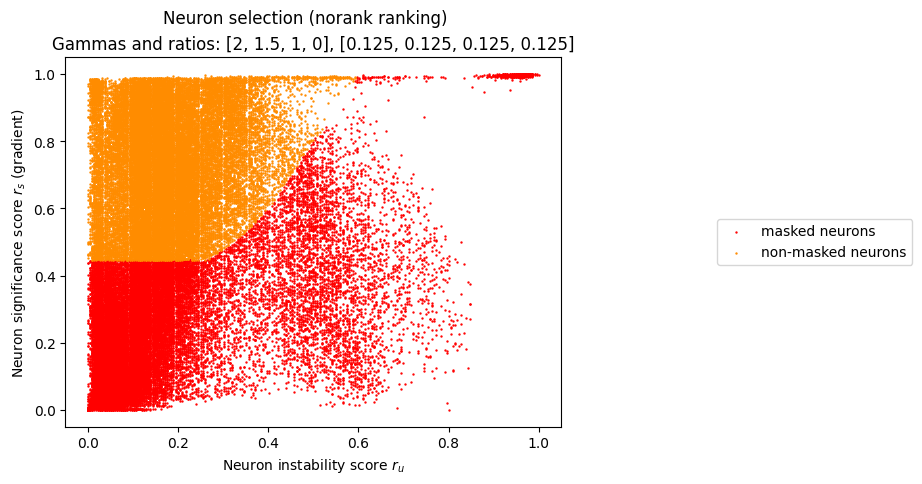

In [21]:
# n = len(mag_mask_idcs)
# num_neurons = [round(n*r) for r in ratios]
# bound_idcs = np.cumsum(num_neurons).tolist()
# x_bounds = [torch.cat(inst_ranks)[mag_mask_idcs[bound_idcs[i]-1]] for i in range(len(num_neurons))]
# print(n)
# print(num_neurons)
# print(x_bounds)


heuristic = "gradient"
method = 'norank'

#approximated grafting scores (weighted average over decay)
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
mod_gammas = [g if g != float("inf") else 1000 for g in gammas ]
gam = sum([g*r for g,r in zip(mod_gammas, ratios)]) / sum(ratios)
z = np.array([gam*i-j for j in y for i in x])
X, Y = np.meshgrid(x, y)
Z = z.reshape(100, 100)
#plt.contourf(X, Y, Z, 100)

flatinst = torch.cat([l.flatten() for l in inst_ranks])
flatgrad = torch.cat([l.flatten() for l in grad_ranks])

# flatinst = torch.zeros_like(flatinst)
# flatmag = 


#Plot Neurons
plt.scatter(flatinst[ordered_grad_idcs], flatgrad[ordered_grad_idcs], c = "r", label = "masked neurons", s = 0.5)
non_masked = [i for i in range(len(flatgrad)) if i not in ordered_grad_idcs]
plt.scatter(flatinst[non_masked], flatgrad[non_masked], c = "darkorange", label = "non-masked neurons", s = 0.5)
#plt.vlines(x_bounds, ymin = 0, ymax = 1)
#plt.colorbar(label = r'weighted avg. of selection criterion $\gamma \times r_u - r_s$')
plt.xlabel(r'Neuron instability score $r_u$')
plt.ylabel(r'Neuron significance score $r_s$ ('+heuristic+')')
plt.legend(loc='center left', bbox_to_anchor=(1.3, 0.5))
plt.suptitle(f"Neuron selection ({method} ranking)")#\n\
             #Gammas and ratios: " + str(gammas) + ", " + str(ratios))
plt.title("Gammas and ratios: " + str(gammas) + ", " + str(ratios))
plt.show()

### Selection criterion tries to mask neurons in the lower right part: High instability and low significance 

In [22]:
# ranking method determines treatment for equal scores
method = 'norank'

norank_grad_ranks = scores_to_global_ranks(grad_scores, method = method)
norank_inst_ranks = scores_to_global_ranks(inst_scores, method = method)

method = 'dense'

dense_grad_ranks = scores_to_global_ranks(grad_scores, method = method)
dense_inst_ranks = scores_to_global_ranks(inst_scores, method = method)

method = 'min'

min_grad_ranks = scores_to_global_ranks(grad_scores, method = method)
min_inst_ranks = scores_to_global_ranks(inst_scores, method = method)



In [23]:
norank_mask, ordered_norank_idcs = global_mask_from_ranks(norank_inst_ranks, norank_grad_ranks, gammas, ratios)
dense_mask, ordered_dense_idcs = global_mask_from_ranks(dense_inst_ranks, dense_grad_ranks, gammas, ratios)
min_mask, ordered_min_idcs = global_mask_from_ranks(min_inst_ranks, min_grad_ranks, gammas, ratios)


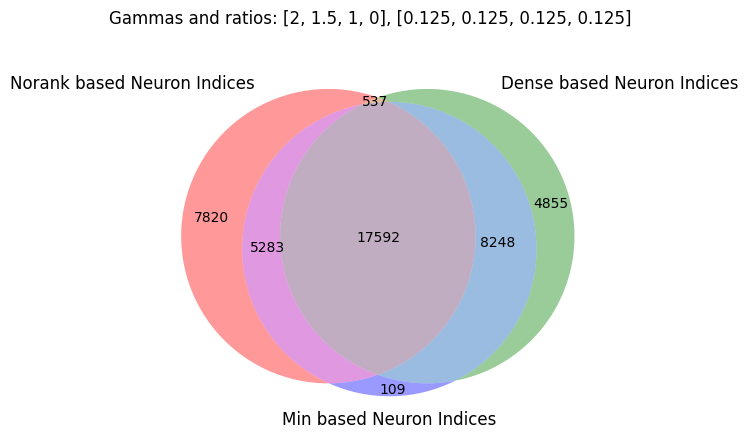

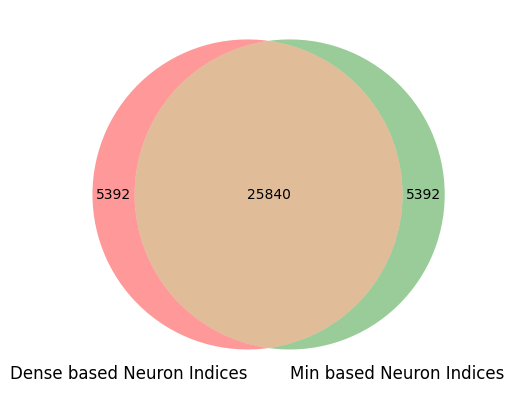

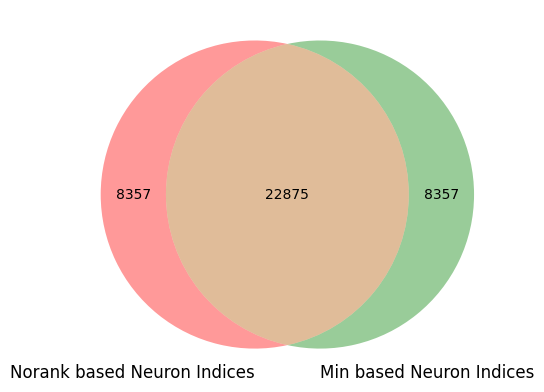

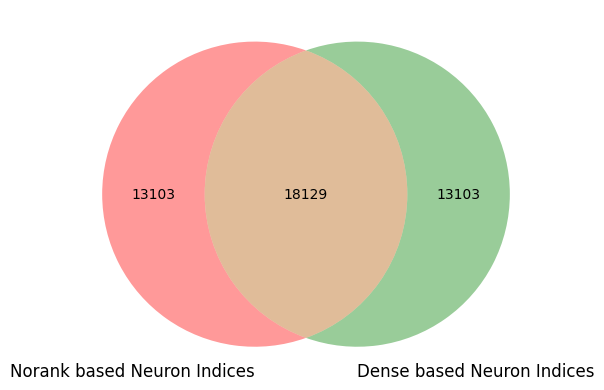

In [24]:
venn3([set(ordered_norank_idcs),set(ordered_dense_idcs), set(ordered_min_idcs)], ["Norank based Neuron Indices", "Dense based Neuron Indices", "Min based Neuron Indices"])
plt.suptitle("Gammas and ratios: " + str(gammas) + ", " + str(ratios))
plt.show()

venn2([set(ordered_dense_idcs), set(ordered_min_idcs)], ["Dense based Neuron Indices", "Min based Neuron Indices"])
plt.show()

venn2([set(ordered_norank_idcs),set(ordered_min_idcs)], ["Norank based Neuron Indices","Min based Neuron Indices"])
plt.show()

venn2([set(ordered_norank_idcs),set(ordered_dense_idcs)], ["Norank based Neuron Indices", "Dense based Neuron Indices"])
plt.show()